# Jitter model for TOLIMAN
In order to properly recover the signal seen by TOLIMAN, we need to understand and account for the jitter of the spacecraft. In this notebook we will to develop a basic jitter model with dLux.

----
## Setup
First let's get the housekeeping out of the way.

In [143]:
import dLux as dl
from jax import numpy as np
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt
import os

os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Let's set our physical parameters for modelling Alpha Centauri:

In [144]:
sep = 10  # binary separation in arcseconds
pa = 90  # position angle in degrees
flux = 6.229e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes
bandwidth_min = 545  # minimum wavelength in nm
bandwidth_max = 645  # maximum wavelength in nm

And our parameters for the optical system:

In [83]:
pixel_scale_in = 10e-7  # Radians per pixel of the detector
wavefront_npixels = 256  # Number of pixels representing the wavefront
detector_npixels = 128  # Number of pixels in the detector
sampling_rate = 5  # five times Nyquist sampling
wavels = 1e-9 * np.linspace(bandwidth_min, bandwidth_max, 3)  # the wavelengths modelled
detector_pixel_size = dl.utils.get_pixel_scale(sampling_rate, wavels.max(), 0.125)  # radians per pixel

Loading in the binary phase mask:

In [84]:
mask_dir = 'data/test_mask.npy'
mask = dl.optics.AddOPD(dl.utils.phase_to_opd(np.load(mask_dir), wavelength=wavels.mean()))

Let's create the system optics and source and combine them to create the instrument:

In [85]:
# Creating a propagator layer which will perform the PSF shifting:
propagator = dl.AngularMFT(detector_npixels, pixel_scale_in, name='Propagator')

# Make optical system
optics = dl.utils.toliman(wavefront_npixels,
                          detector_npixels,
                          detector_pixel_size=dl.utils.radians_to_arcseconds(detector_pixel_size),
                          extra_layers=[mask],#, propagator],
                          angular=True,
                          )

# Resetting the pixel scale of output
optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(.3)])

# Creating a model Alpha Cen source
source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(sep),
                         wavelengths=wavels,
                         contrast=contrast,
                         flux=flux,
                         position_angle=np.deg2rad(pa),
                         )

# Creating the instrument by combining optics and source
tel = dl.Instrument(optics=optics, sources=[source])

Defining a function for plotting PSFs:

In [145]:
def plot_psf(PSF):
    fig, ax = plt.subplots()
    c = ax.imshow(PSF**.5)
    ax.set(
            # title=r'$\alpha$ $Cen$ Simulated sqrt PSF',
            xticks=[0, PSF.shape[0] - 1],
            yticks=[0, PSF.shape[1] - 1],
            )
    fig.colorbar(c, ax=ax, label='photons')
    plt.show()
    return

Plotting the jitterless PSF:

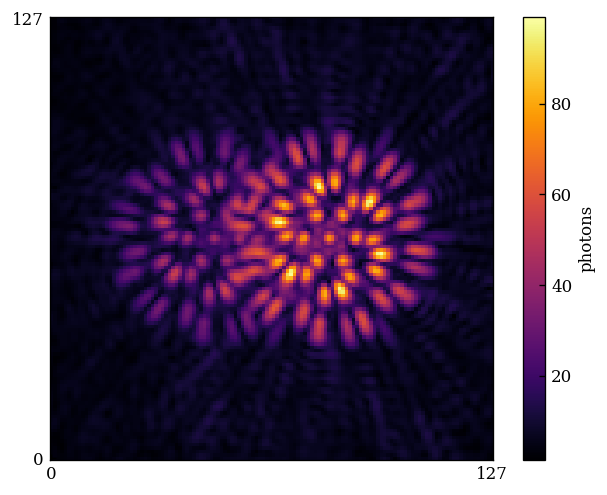

In [147]:
PSF = tel.model()
plot_psf(PSF)

____
## Modelling the Jitter

We are going to the model the jitter as the normalised sum of several identical shifted PSFs. The challenge is to identify a number of PSFs (`npsf`) that is sufficient to represent a continuous motion, but not so many that the computation time becomes prohibitive. For now, let's set it at 10.

We will also need to define the positions of the PSFs. I will just choose these randomly for now, and later we will build a function that takes a radial vector as an input.

In [153]:
npsf = 10  # number of PSFs

# defining positions
centre = np.array([0, 0])  # pixels
xs = np.linspace(-5, 5, npsf)  # pixels
ys = np.linspace( -10, 10, npsf)  # pixels
pscale = optics.AngularMFT.pixel_scale_out  # arcseconds per pixel
positions = pscale * (np.stack([xs, ys], axis=1) + centre)  # arcseconds

Now let's use `jax.vmap` to vectorise this operation. Each PSF is then summed and renormalised to give the jittered PSF.

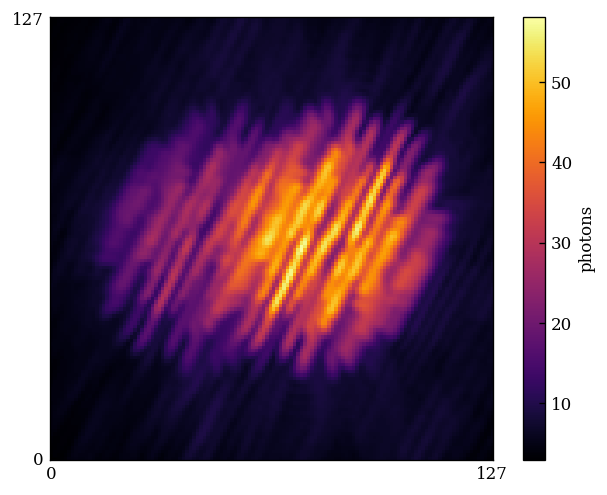

In [154]:
# Defining a function to set the source position and propagate through the optics
def set_and_model(optics, source, pos):
    src = source.set(['position'], [pos])
    return optics.model(src)

vmap_prop = vmap(set_and_model, in_axes=(None, None, 0))
psfs = vmap_prop(optics, source, positions)
jit_psf = psfs.sum(0) / npsf  # adding and renormalising

plot_psf(jit_psf)

This is a good proof of concept. This amount of jitter is huge and unrealistic, but it shows that the model is working. Furthermore, it seems that 10 PSFs are sufficient for this level of jitter to appear as a continuous motion -- at least visually.